In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
from scipy.constants import c, pi
import scipy.special as sc
from diffraction import length, unit, D_s_h

In [2]:
def Et(theta, r=1e6, f=1e9):

    l = c / f
    k = 2 * pi / l
    a = 3 * l

    E = complex(0)
    # E = zeros_like(theta, dtype=complex64)  # theta direction

    ejkr_r = exp(-1j * k * r) / r
    n = 2

    los = (theta > 0) * (theta < pi / 2)

    E += 1 * los * sin(theta) * ejkr_r

    # E[los] += 0 * sin(theta[los]) * ejkr_r

    beta_0 = pi / 2

    # Q
    rho = a / sin(theta)
    phi_p = 0
    phi = pi / 2 + theta
    Li = Lro = Lrn = a
    _, D_h = D_s_h(n, k, beta_0, phi, phi_p, Li, Lrn, Lro)
    
    s = np.linalg.norm([r * sin(theta) - a, 0, r * cos(theta)])
    factor = np.sqrt(rho / (s * (s + rho))) * np.exp(-1j * k * s)
    
    EdQ = (
        0.5 * D_h * ejkr_r * exp(-1j * k * a * (1 - sin(theta))) / sqrt(a * sin(theta))
    )
    
    EdQ = (
        + 0.5 * D_h * factor * (exp(-1j * k * a) / a)
    )

    # P

    phi = (pi / 2 - theta) * los + (5 * pi / 2 - theta) * (1 - los)

    # print((n, k, beta_0, phi[0], phi_p[0], Li, Lrn, Lro))

    # for a1, a2, a3 in zip(theta, phi, phi_p):
    #    print(f"theta = {a1:.4}, phi = {a2:.4}, phi' = {a3:.4}")

    _, D_h = D_s_h(n, k, beta_0, phi, phi_p, Li, Lrn, Lro)
    # print("D_h", D_h)
    EdP = (
        -1j
        * 0.5
        * D_h
        * ejkr_r
        * exp(-1j * k * a * (1 + sin(theta)))
        / np.sqrt(a * sin(theta))
    )
    
    s = np.linalg.norm([r * sin(theta) + a, 0, r * cos(theta)])
    rho = complex(-a / sin(theta))
    factor = np.sqrt(rho / (s * (s + rho))) * np.exp(-1j * k * s)
    
    EdP = (
        - 0.5 * D_h * factor * (exp(-1j * k * a) / a)
    )

    return E + EdP + EdQ

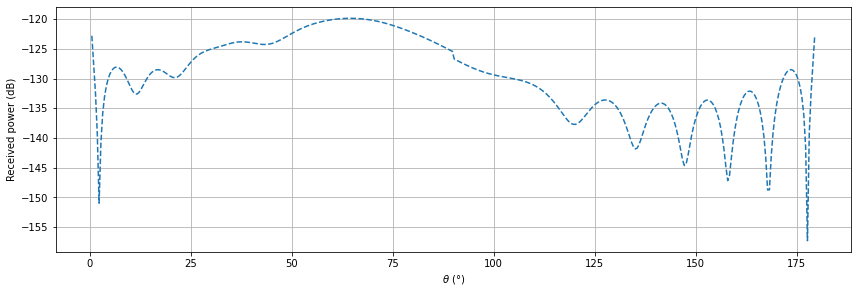

In [3]:
n = 400

theta = np.linspace(0.01, pi - 0.01, n)

# E1 = Et(theta, r=1e6)
E1 = np.zeros(n, dtype=complex64)

for i in range(n):
    E1[i] = Et(theta[i], r=1e6)
P = 20 * np.log10(abs(E1))
# P = P - np.max(P)
plt.figure(figsize=(28.5 / 2, 9 / 2))
# plt.figure(figsize=(11.5 /2 , 9.5 / 2))
plt.plot(np.rad2deg(theta), P, "--")
plt.xlabel(r"$\theta$ (°)")
plt.ylabel(r"Received power (dB)")
plt.grid("on")
np.savetxt("P3.txt", P)